# 1. Library Imports
Purpose: Import necessary libraries for preprocessing, modeling, and evaluation.

In [19]:
# General and Data Libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Image Processing
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Data Balancing
from imblearn.over_sampling import RandomOverSampler

# Visualization Style
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")



# 2. Load Dataset
Purpose: Load metadata and verify dataset structure.

In [20]:
# Load metadata
data = pd.read_csv('/kaggle/input/isic-2019-skin-lesion-images-for-classification/ISIC_2019_Training_GroundTruth.csv')
print("Data Shape:", data.shape)

# Check image folder structure
dataset_path = '/kaggle/input/isic-2019-skin-lesion-images-for-classification/'
print(os.listdir(dataset_path))


Data Shape: (25331, 10)
['MEL', 'VASC', 'SCC', 'DF', 'NV', 'ISIC_2019_Training_GroundTruth.csv', 'ISIC_2019_Training_Metadata.csv', 'BKL', 'BCC', 'AK']


# 3. Image Loading and Preprocessing
## 3.1 Define Image Loader
Purpose: Load and resize images to the required input shape.

In [21]:
def load_and_resize_images(image_paths, target_size=(28, 28)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # Load and resize
        img_array = img_to_array(img)  # Convert to array
        images.append(img_array)
    return np.array(images)


## 3.2 Load Images by Class
Purpose: Load all images and assign corresponding labels.

In [22]:
# Define classes
class_folders = ['MEL', 'VASC', 'SCC', 'DF', 'NV', 'BKL', 'BCC', 'AK']

# Load images and labels
all_images, all_labels = [], []

for class_name in class_folders:
    class_folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_folder_path)
    class_images = load_and_resize_images([os.path.join(class_folder_path, img) for img in image_files])
    all_images.append(class_images)
    all_labels.append([class_name] * len(image_files))

# Combine all data
X_all = np.concatenate(all_images, axis=0)
y_all = np.concatenate(all_labels, axis=0)

print("Shape of all images:", X_all.shape)
print("Shape of all labels:", y_all.shape)


Shape of all images: (25331, 28, 28, 3)
Shape of all labels: (25331,)


# 4. Data Preprocessing
## 4.1 Encode and Balance Data
Purpose: Convert labels to one-hot encoding and balance classes using oversampling.

In [23]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_all)
y_one_hot = to_categorical(y_encoded)

# Reshape data for oversampling
X_reshaped = X_all.reshape(X_all.shape[0], -1)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_one_hot)

print("Class distribution after oversampling:", Counter(np.argmax(y_resampled, axis=1)))


Class distribution after oversampling: Counter({4: 12875, 7: 12875, 6: 12875, 3: 12875, 5: 12875, 2: 12875, 1: 12875, 0: 12875})


## 4.2 Split Data
Purpose: Create training and testing datasets

In [24]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")


Shapes - X_train: (82400, 2352), X_test: (20600, 2352), y_train: (82400, 8), y_test: (20600, 8)


## 4.3 Reshape Data
Purpose: Restore original shape for model training.

In [25]:
# Reshape to (28, 28, 3)
X_train_reshaped = X_train.reshape(X_train.shape[0], 28, 28, 3)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28, 28, 3)


# 5. Model Building
## 5.1 Define Model
Purpose: Create CNN architecture with L2 regularization to prevent overfitting.

In [26]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), input_shape=(28, 28, 3)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(8, activation='softmax')
])


## 5.2 Compile Model
Purpose: Set optimizer, loss function, and evaluation metrics.

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# 6. Model Training
Purpose: Train the CNN with callbacks for learning rate reduction and early stopping.

In [28]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=100, batch_size=64, callbacks=callbacks)


Epoch 1/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4186 - loss: 7.6050 - val_accuracy: 0.4793 - val_loss: 2.2021 - learning_rate: 0.0010
Epoch 2/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5817 - loss: 1.9350 - val_accuracy: 0.4698 - val_loss: 2.2151 - learning_rate: 0.0010
Epoch 3/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6212 - loss: 1.8154 - val_accuracy: 0.6133 - val_loss: 1.7901 - learning_rate: 0.0010
Epoch 4/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6482 - loss: 1.7333 - val_accuracy: 0.6589 - val_loss: 1.6913 - learning_rate: 0.0010
Epoch 5/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6641 - loss: 1.6794 - val_accuracy: 0.6887 - val_loss: 1.5970 - learning_rate: 0.0010
Epoch 6/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6789 - loss: 1.6173 - val_accuracy: 0.5865 - val_loss: 1.9036 - learning_rate: 0.0010
Epoch 7/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.

# 7. Evaluation
## 7.1 Plot Training Metrics
Purpose: Visualize training and validation accuracy/loss.


In [30]:

import matplotlib.pyplot as plt
import numpy as np

# Plotting Training and Validation Metrics
def plot_training(hist):
    # Extracting accuracy and loss values
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    # Finding the best epochs for loss and accuracy
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Plot settings
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'Best Epoch = {index_loss + 1}'
    acc_label = f'Best Epoch = {index_acc + 1}'

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


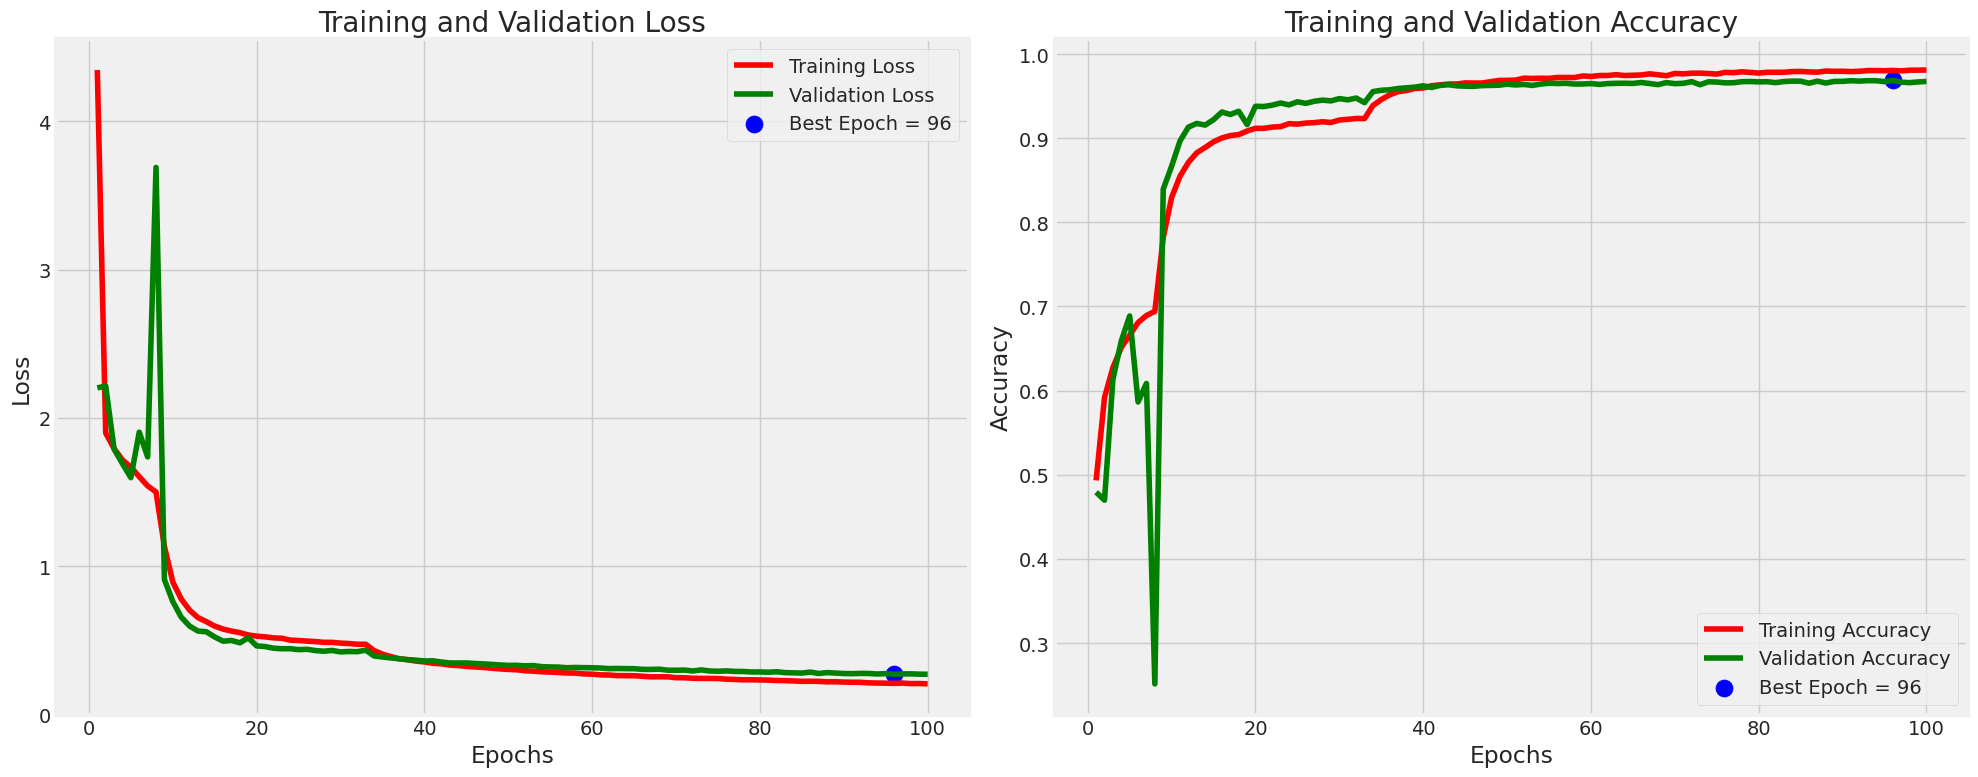

In [31]:
plot_training(history)

## 7.2 Test Performance
Purpose: Evaluate the model on test data

In [32]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9680 - loss: 0.2791
Test Accuracy: 96.86%
Test Loss: 0.2712


# 7.3 Classification Report and Confusion Matrix
Purpose: Assess performance per class.

644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

          AK       0.99      1.00      1.00      2582
         BCC       0.94      0.99      0.97      2665
         BKL       0.96      0.99      0.97      2582
          DF       1.00      1.00      1.00      2517
         MEL       0.92      0.93      0.92      2612
          NV       0.94      0.84      0.89      2557
         SCC       0.99      1.00      1.00      2550
        VASC       1.00      1.00      1.00      2535

    accuracy                           0.97     20600
   macro avg       0.97      0.97      0.97     20600
weighted avg       0.97      0.97      0.97     20600



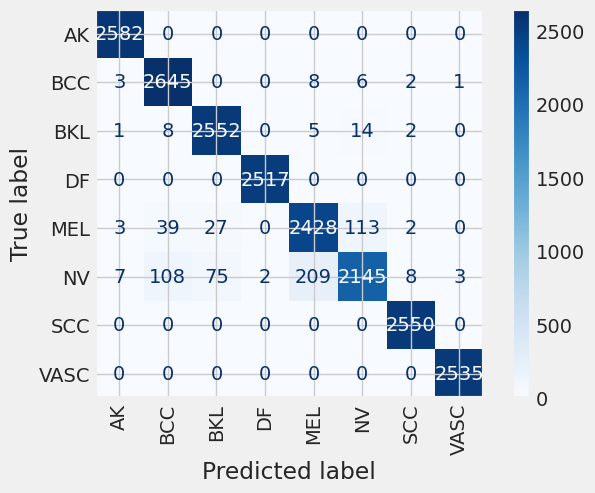

In [33]:
y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()


In [34]:
model.save("ImranIsicModle.h5")